In [65]:
# Import library
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(3)

# Import data

In [66]:
# Import data
train = np.genfromtxt('train.csv',delimiter=",")
dev = np.genfromtxt('dev.csv',delimiter=",")
test = np.genfromtxt('test.csv',delimiter=",")

# Pre-process data
X_train = train[:, 0:2]
y_train = train[:, 2]
X_dev = dev[:, 0:2]
y_dev = dev[:, 2]
X_test = test

# Split training data into label 1 and label2
train_1 = train[train[: ,2] == 1]
X_train_1 = train_1[:, 0:2]
y_train_1 = train_1[:, 2]

train_2 = train[train[:, 2] == 2]
X_train_2 = train_2[:, 0:2]
y_train_2 = train_2[:, 2]

In [67]:
print('X_train shape:' + str(X_train.shape))
print('y_train shape:' + str(y_train.shape))
print('X_train_1 shape:' + str(X_train_1.shape))
print('y_train_1 shape:' + str(y_train_1.shape))
print('X_train_2 shape:' + str(X_train_2.shape))
print('y_train_2 shape:' + str(y_train_2.shape))
print('X_dev shape:' + str(X_dev.shape))
print('y_dev shape:' + str(y_dev.shape))
print('X_test shape:' + str(X_test.shape))

X_train shape:(4800, 2)
y_train shape:(4800,)
X_train_1 shape:(2400, 2)
y_train_1 shape:(2400,)
X_train_2 shape:(2400, 2)
y_train_2 shape:(2400,)
X_dev shape:(400, 2)
y_dev shape:(400,)
X_test shape:(320, 2)


# Visualize data

Before we start implementing our Gaussian Mixture model, it is a good idea to create a visualization to see if there is any noticeable structure in our training data.

Here we draw a scatterplot of the training data. Using X-axis to represent dimension 1, and Y-axis to represent dimension 2. The red dots represent all the training data with label 1, and the blue dots represent all the training data with label 2.

The scatterplot shows that the training data forms 8 different clusters. More specifically, there are 4 clusters for label 1 and label 2 respectively. This will give us some insight into the number of Gaussians we should choose as the hyperparameter for the Gaussian Mixture Model. 

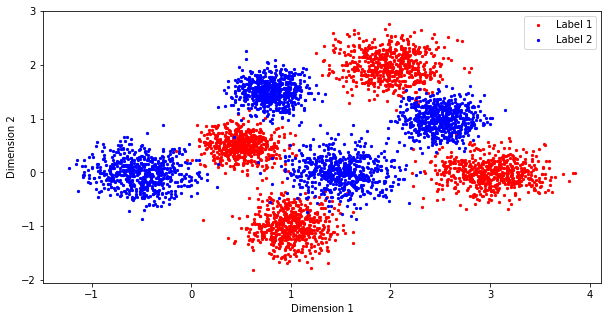

In [68]:
# Visualize data
plt.figure(figsize=(10,5))
plt.scatter(X_train_1[:, 0] , X_train_1[:, 1] , marker='o', c = 'red', s = 5, label = 'Label 1')
plt.scatter(X_train_2[:, 0] , X_train_2[:, 1] ,marker='o', c = 'blue', s = 5, label = 'Label 2')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# Parameters Initialization

Before we begin the EM algorithm, we must initialize the parameters we wish to estimate to some values. 
There are many different ways to initialize the parameters. But for this assignment, I chose to initialize the mean 
and covariance matrix to random values in the range of minimum and maximum value of the training dataset. However,
for the mixing coefficient, I set each Gaussian to have a uniform distribution for simplicity. 

In [69]:
def initialize_parameters(X, num):
    """
    This function initializes parameters for GMM that we can use 
    for EM Algorithm. 
    
    Inputs have dimension N, we operate on M examples.
    
    Inputs:
    - X: A numpy array of shape (M, N) containing our training data.
    - num: The number of Gaussians for GMM
    
    Returns:
    - params: A list containing mean, covariance, mixing coefficient for GMM
    
    """
    
    # Number of dimensions
    N = X.shape[1]
    
    # Get minimum and maximum values of the traing dataset
    minimum = X.min() 
    maximum = X.max()
    
    # Create empty dictionaries to store mean, covariance, and mixing coefficient (weight)
    mean = {}
    covariance = {}
    w = {}
    
    # Initialize values for parameters
    for i in range(num):
        # Mean
        mean['u' + str(i)] = np.random.uniform(low = minimum, high = maximum, size = (N, 1))
        # Covariance
        tmp = np.random.uniform(low = minimum, high = maximum, size = (N, N))
        covariance['s' + str(i)] = np.dot(tmp, tmp.T) # To ensure the covariance matrix is positive semidefinite
        # Mixing Coefficient
        w['w' + str(i)] = 1 / num
    
    # Store mean, covariance, and w in variable params
    params = [mean, covariance, w]
    
    return params

In [70]:
#params = initialize_parameters(X_train_1, 4)
#params

[{'u0': array([[ 1.3083555 ],
         [ 2.20113015]]), 'u1': array([[-1.10422293],
         [-0.64091283]]), 'u2': array([[ 1.86635353],
         [-0.23668512]]), 'u3': array([[-0.34582006],
         [ 0.53843723]])}, {'s0': array([[  1.19742925,   2.99506751],
         [  2.99506751,  21.24415801]]),
  's1': array([[ 2.79315048,  3.04215069],
         [ 3.04215069,  3.31442328]]),
  's2': array([[ 6.4394116 , -1.31590795],
         [-1.31590795,  4.6582514 ]]),
  's3': array([[ 4.52062136, -2.10291851],
         [-2.10291851,  1.3243423 ]])}, {'w0': 0.25,
  'w1': 0.25,
  'w2': 0.25,
  'w3': 0.25}]

# E-Step

In [71]:
def E_step(X, params):
    """
    Inputs have dimension N, we operate on M examples.
    
    Inputs:
    - X: A numpy array of shape (M, N) containing our training data.
    - params: A list containing mean, covariance, mixing coefficient
    
    Returns:
    - Z: A dictionary containing latent variables of each data point with
        respect to each Gaussian
    """
    
    # Number of dimensions
    N = X.shape[1]
    # Number of training examples
    M = X.shape[0]
    # Number of Gaussians
    K = len(params[2])
    
    # Get parameters mean, covariance, and mixing coefficient
    mean = params[0]
    covariance = params[1]
    w = params[2]
    
    # Calculate gaussian pdf
    G = {}
    
    for i in range(K):
        gaussian = multivariate_normal(mean = np.squeeze(mean['u' + str(i)]), cov = covariance['s' + str(i)], allow_singular = True)
        G['g' + str(i)] = gaussian.pdf(X)
    
    # Calculate latent variables
    Z = {}
    denominator = np.zeros((1, M))
    for i in range(K):
        denominator += G['g' + str(i)]
    
    for i in range(K):
        numerator = G['g' + str(i)]
        Z['z' + str(i)] = numerator / denominator
    
    return Z

In [72]:
#Z = E_step(X_train_1, params)
#Z

# M-Step

In [73]:
def M_step(X, Z):
    """
    Inputs:
    - X: A numpy array of shape (M, N) containing our training data.
    - Z: A dictionary containing latent variables of each data point with
        respect to each Gaussian
        
    Returns:
    - mean: An updated mean vector
    - covariance: An updated covariance matrix
    
    """
    
    # Number of dimensions
    N = X.shape[1]
    # Number of training examples
    M = X.shape[0]
    # Number of Gaussians
    K = len(Z)
    
    
    # Updated mean vector
    mean = {}
    for i in range(K):
        mean['u' + str(i)] = np.sum( (X * Z['z' + str(i)].T), axis=0 ) / np.sum(Z['z' + str(i)])
    
    
    # Updated covariance matrix
    covariance = {}
    for i in range(K):
        d = np.zeros((N, N))
        for j in range(M):
            a = X[j,:].reshape(1, N) - mean['u' + str(i)].reshape(1, N)
            b = np.dot(a.T, a)
            c = Z['z' + str(i)][0, j] * b
            d += c
        d /= np.sum(Z['z' + str(i)])
        covariance['s' + str(i)] = d
    
    return mean, covariance

In [74]:
# mean, covariance = M_step(X_train_1, Z)
# print(mean)
# print(covariance)

# Expectation Maximization

In [75]:
def expectation_maximization(X, num, iteration, verbose=False):
    """
    Inputs:
        X: A numpy array of shape (M, N) containing our training data.
        num: Number of Gaussians
        iteration: Number of iterations
        verbose: Shows log-likelihood change for convergence
        
    Returns:
        params: A list containing the estimated mean, covariance matrix, and mixing coefficient
        
    """
    # Initialize parameters
    params = initialize_parameters(X, num)
    
    # Get numebr of gaussian
    K = len(params[2])
    M = X.shape[0]
    
    for i in range(iteration):
        
        # Store old parameters
        old_mean = params[0]
        old_covariance = params[1]
        w = params[2] 
        
        # E-Step
        Z = E_step(X, params)
        
        # M-Step
        mean, covariance = M_step(X, Z)
        
        # Update parameters
        params[0] = mean
        params[1] = covariance
        
        # Calculate likelihood change
        if verbose == True:
            tmp = np.zeros(M)
            for j in range(K):
                gaussian = multivariate_normal(mean = np.squeeze(mean['u' + str(j)]), cov = covariance['s' + str(j)], allow_singular = True)
                tmp += w['w' + str(j)] * gaussian.pdf(X)
            tmp = np.log(tmp)
            log_likelihood = np.sum(tmp)
             
            print('Iteration %d | likelihood: %f' % (i+1, log_likelihood))

    return params

In [76]:
#parameters = expectation_maximization(X_train, 8, 200, True)

# Gaussian Mixture Model

In [79]:
def GMM(X, params):
    """
    Input:
        X: A numpy array of shape (M, N) containing our data
        params: A list containing mean, covariance matrix, and mixing coefficient
    
    Returns:
        probability: Estimated probabilities for each data point using GMM
        
    """
    
    # Get parameters
    mean = params[0]
    covariance = params[1]
    w = params[2]
    M = X.shape[0]
    K = len(params[2])
    
    # Initialize probability
    probability = np.zeros(M)
    
    for i in range(K):
        g = multivariate_normal(mean = np.squeeze(mean['u' + str(i)]), cov = covariance['s' + str(i)], allow_singular = True)
        probability += w['w' + str(i)] * g.pdf(X)
    
    return probability

# Classification using GMM

In [80]:
def GMM_classify(X, params1, params2):
    """
    Input:
        X: A numpy array of shape (M, N) containing our data
        params1: Parameters of GMM model for label 1
        params2: Parameters of GMM model for label 2
    Returns:
        prediction: A numpy array of containing the classification results
    """
    
    # Number of examples
    M = X.shape[0]
    
    # Estimated probabilities for each GMM
    prob_1 = GMM(X, params1)
    prob_2 = GMM(X, params2)

    # Compare each example and see which GMM produces the highest probability
    a = zip(prob_1, prob_2)
    lst = [i for i in a]
    lst = np.array(lst)
    lst = np.argmax(lst, axis = 1)
    
    # Output the correct prediction according to the max probability
    prediction = np.zeros(M)
    for i in range(M):
        if lst[i] == 0:
            prediction[i] = 1
        else:
            prediction[i] = 2
            
    return prediction

# Hyperparameter Tuning using Development Set

The most important hyperparameter to tune in GMM is the number of Gaussian we should have. Therefore, we will use the development set data to search the optimal number of Gaussians that gives us the highest development set accuracy.

In [97]:
def cross_validation(num_gaussian_lst, verbose = False):
    # A list containing different number of Gaussian
    K_list = num_gaussian_lst

    # Create empty dictionaries to store the accuracies of training data and development data
    train_accuracy_lst = {}
    dev_accuracy_lst = {}

    # Best accuracy and parameters
    best_accuracy = 0.0
    best_parameters_1 = None
    best_parameters_2 = None

    # Cross-validation
    for i in K_list:
        # Finding parameters using Expectation Maximization
        print('Number of Gaussians : %f || Label 1' % i)
        parameters_1 = expectation_maximization(X_train_1, i, 500, verbose)
        print('Number of Gaussians : %f || Label 2' % i)
        parameters_2 = expectation_maximization(X_train_2, i, 500, verbose)

        # Make prediction using GMM for training set data
        train_prediction = GMM_classify(X_train, parameters_1, parameters_2)
        train_accuracy = np.mean(y_train == train_prediction)

        # Make prediction using GMM for development set data
        dev_prediction = GMM_classify(X_dev, parameters_1, parameters_2)
        dev_accuracy = np.mean(y_dev == dev_prediction)

        # Append accuracies to dictionaries
        train_accuracy_lst[str(i)] = train_accuracy
        dev_accuracy_lst[str(i)] = dev_accuracy

        # Compare with original accuracy to see if it is abetter
        if dev_accuracy > best_accuracy:
            best_accuracy = dev_accuracy
            best_parameters_1 = parameters_1
            best_parameters_2 = parameters_2
    
    print('Training set accuracy: ')
    print(train_accuracy_lst)
    print('Development set accuracy: ')
    print(dev_accuracy_lst)

# Classification Accuracy

The number of Gaussians we will try on the development set data are [2, 4, 6, 8]. We will run the expectation maximization algorithm for 500 iterations. To check for convergence, we will use the log likelihood to check if there is noticeable difference from one iteration to the next. Lastly, we will also compute the training set data accuracy and development set data accuracy to pick out the optimal number of Gaussians.

We can see that by tuning our hyperparameter on the development set data, it tells us that the optimal number of Gaussians for each of the GMMs is 8. We make the following observation regarding convergence: 

>When the number of Gaussians is 2, we see that the Expectation Maximization converges after 10 iterations for GMM model of label 1, and 12 iteartions for GMM model of label 2.

>When the number of Gaussians is 4, we see that the Expectation Maximization converges after 36 iterations for GMM model of label 1, and 96 iterations for GMM model of label 2.

>When the number of Gaussians is 6, we see that the Expectation Maximization converges after 414 iterations for GMM model of label 1, and 383 iterations for GMM model of label 2.

>When the number of Gaussians is 8, we see that the Expectation Maximization converges after 338 iterations for GMM model of label 1, and 391 iterations for GMM model of label 2.

But since increasing the number of Gaussians from 4 to 8 only gives us around 3% increase in accuracy. One of the risks of GMM model is to use too many Gaussians and risk overfitting. To avoid overfitting, we will choose 4 as the optimal number of Gaussians. 

In [98]:
cross_validation([2, 4, 6, 8], True)

Number of Gaussians : 2.000000 || Label 1
Iteration 1 | likelihood: -7229.697577
Iteration 2 | likelihood: -6764.810309
Iteration 3 | likelihood: -6426.591130
Iteration 4 | likelihood: -6137.630069
Iteration 5 | likelihood: -5739.535892
Iteration 6 | likelihood: -5131.633307
Iteration 7 | likelihood: -4981.269857
Iteration 8 | likelihood: -4981.265977
Iteration 9 | likelihood: -4981.265977
Iteration 10 | likelihood: -4981.265977
Iteration 11 | likelihood: -4981.265977
Iteration 12 | likelihood: -4981.265977
Iteration 13 | likelihood: -4981.265977
Iteration 14 | likelihood: -4981.265977
Iteration 15 | likelihood: -4981.265977
Iteration 16 | likelihood: -4981.265977
Iteration 17 | likelihood: -4981.265977
Iteration 18 | likelihood: -4981.265977
Iteration 19 | likelihood: -4981.265977
Iteration 20 | likelihood: -4981.265977
Iteration 21 | likelihood: -4981.265977
Iteration 22 | likelihood: -4981.265977
Iteration 23 | likelihood: -4981.265977
Iteration 24 | likelihood: -4981.265977
Iterati

Iteration 203 | likelihood: -4981.265977
Iteration 204 | likelihood: -4981.265977
Iteration 205 | likelihood: -4981.265977
Iteration 206 | likelihood: -4981.265977
Iteration 207 | likelihood: -4981.265977
Iteration 208 | likelihood: -4981.265977
Iteration 209 | likelihood: -4981.265977
Iteration 210 | likelihood: -4981.265977
Iteration 211 | likelihood: -4981.265977
Iteration 212 | likelihood: -4981.265977
Iteration 213 | likelihood: -4981.265977
Iteration 214 | likelihood: -4981.265977
Iteration 215 | likelihood: -4981.265977
Iteration 216 | likelihood: -4981.265977
Iteration 217 | likelihood: -4981.265977
Iteration 218 | likelihood: -4981.265977
Iteration 219 | likelihood: -4981.265977
Iteration 220 | likelihood: -4981.265977
Iteration 221 | likelihood: -4981.265977
Iteration 222 | likelihood: -4981.265977
Iteration 223 | likelihood: -4981.265977
Iteration 224 | likelihood: -4981.265977
Iteration 225 | likelihood: -4981.265977
Iteration 226 | likelihood: -4981.265977
Iteration 227 | 

Iteration 403 | likelihood: -4981.265977
Iteration 404 | likelihood: -4981.265977
Iteration 405 | likelihood: -4981.265977
Iteration 406 | likelihood: -4981.265977
Iteration 407 | likelihood: -4981.265977
Iteration 408 | likelihood: -4981.265977
Iteration 409 | likelihood: -4981.265977
Iteration 410 | likelihood: -4981.265977
Iteration 411 | likelihood: -4981.265977
Iteration 412 | likelihood: -4981.265977
Iteration 413 | likelihood: -4981.265977
Iteration 414 | likelihood: -4981.265977
Iteration 415 | likelihood: -4981.265977
Iteration 416 | likelihood: -4981.265977
Iteration 417 | likelihood: -4981.265977
Iteration 418 | likelihood: -4981.265977
Iteration 419 | likelihood: -4981.265977
Iteration 420 | likelihood: -4981.265977
Iteration 421 | likelihood: -4981.265977
Iteration 422 | likelihood: -4981.265977
Iteration 423 | likelihood: -4981.265977
Iteration 424 | likelihood: -4981.265977
Iteration 425 | likelihood: -4981.265977
Iteration 426 | likelihood: -4981.265977
Iteration 427 | 

Iteration 105 | likelihood: -5822.856798
Iteration 106 | likelihood: -5822.856798
Iteration 107 | likelihood: -5822.856798
Iteration 108 | likelihood: -5822.856798
Iteration 109 | likelihood: -5822.856798
Iteration 110 | likelihood: -5822.856798
Iteration 111 | likelihood: -5822.856798
Iteration 112 | likelihood: -5822.856798
Iteration 113 | likelihood: -5822.856798
Iteration 114 | likelihood: -5822.856798
Iteration 115 | likelihood: -5822.856798
Iteration 116 | likelihood: -5822.856798
Iteration 117 | likelihood: -5822.856798
Iteration 118 | likelihood: -5822.856798
Iteration 119 | likelihood: -5822.856798
Iteration 120 | likelihood: -5822.856798
Iteration 121 | likelihood: -5822.856798
Iteration 122 | likelihood: -5822.856798
Iteration 123 | likelihood: -5822.856798
Iteration 124 | likelihood: -5822.856798
Iteration 125 | likelihood: -5822.856798
Iteration 126 | likelihood: -5822.856798
Iteration 127 | likelihood: -5822.856798
Iteration 128 | likelihood: -5822.856798
Iteration 129 | 

Iteration 305 | likelihood: -5822.856798
Iteration 306 | likelihood: -5822.856798
Iteration 307 | likelihood: -5822.856798
Iteration 308 | likelihood: -5822.856798
Iteration 309 | likelihood: -5822.856798
Iteration 310 | likelihood: -5822.856798
Iteration 311 | likelihood: -5822.856798
Iteration 312 | likelihood: -5822.856798
Iteration 313 | likelihood: -5822.856798
Iteration 314 | likelihood: -5822.856798
Iteration 315 | likelihood: -5822.856798
Iteration 316 | likelihood: -5822.856798
Iteration 317 | likelihood: -5822.856798
Iteration 318 | likelihood: -5822.856798
Iteration 319 | likelihood: -5822.856798
Iteration 320 | likelihood: -5822.856798
Iteration 321 | likelihood: -5822.856798
Iteration 322 | likelihood: -5822.856798
Iteration 323 | likelihood: -5822.856798
Iteration 324 | likelihood: -5822.856798
Iteration 325 | likelihood: -5822.856798
Iteration 326 | likelihood: -5822.856798
Iteration 327 | likelihood: -5822.856798
Iteration 328 | likelihood: -5822.856798
Iteration 329 | 

Iteration 4 | likelihood: -5699.208172
Iteration 5 | likelihood: -5598.105000
Iteration 6 | likelihood: -5500.275495
Iteration 7 | likelihood: -5467.718500
Iteration 8 | likelihood: -5454.670158
Iteration 9 | likelihood: -5447.286673
Iteration 10 | likelihood: -5441.916326
Iteration 11 | likelihood: -5437.713682
Iteration 12 | likelihood: -5434.587767
Iteration 13 | likelihood: -5432.462369
Iteration 14 | likelihood: -5431.124832
Iteration 15 | likelihood: -5430.316479
Iteration 16 | likelihood: -5429.825988
Iteration 17 | likelihood: -5429.514537
Iteration 18 | likelihood: -5429.301213
Iteration 19 | likelihood: -5429.141641
Iteration 20 | likelihood: -5429.012142
Iteration 21 | likelihood: -5428.900192
Iteration 22 | likelihood: -5428.799147
Iteration 23 | likelihood: -5428.705429
Iteration 24 | likelihood: -5428.617051
Iteration 25 | likelihood: -5428.532851
Iteration 26 | likelihood: -5428.452088
Iteration 27 | likelihood: -5428.374247
Iteration 28 | likelihood: -5428.298928
Iterat

Iteration 207 | likelihood: -3331.810914
Iteration 208 | likelihood: -3331.810914
Iteration 209 | likelihood: -3331.810914
Iteration 210 | likelihood: -3331.810914
Iteration 211 | likelihood: -3331.810914
Iteration 212 | likelihood: -3331.810914
Iteration 213 | likelihood: -3331.810914
Iteration 214 | likelihood: -3331.810914
Iteration 215 | likelihood: -3331.810914
Iteration 216 | likelihood: -3331.810914
Iteration 217 | likelihood: -3331.810914
Iteration 218 | likelihood: -3331.810914
Iteration 219 | likelihood: -3331.810914
Iteration 220 | likelihood: -3331.810914
Iteration 221 | likelihood: -3331.810914
Iteration 222 | likelihood: -3331.810914
Iteration 223 | likelihood: -3331.810914
Iteration 224 | likelihood: -3331.810914
Iteration 225 | likelihood: -3331.810914
Iteration 226 | likelihood: -3331.810914
Iteration 227 | likelihood: -3331.810914
Iteration 228 | likelihood: -3331.810914
Iteration 229 | likelihood: -3331.810914
Iteration 230 | likelihood: -3331.810914
Iteration 231 | 

Iteration 407 | likelihood: -3331.810914
Iteration 408 | likelihood: -3331.810914
Iteration 409 | likelihood: -3331.810914
Iteration 410 | likelihood: -3331.810914
Iteration 411 | likelihood: -3331.810914
Iteration 412 | likelihood: -3331.810914
Iteration 413 | likelihood: -3331.810914
Iteration 414 | likelihood: -3331.810914
Iteration 415 | likelihood: -3331.810914
Iteration 416 | likelihood: -3331.810914
Iteration 417 | likelihood: -3331.810914
Iteration 418 | likelihood: -3331.810914
Iteration 419 | likelihood: -3331.810914
Iteration 420 | likelihood: -3331.810914
Iteration 421 | likelihood: -3331.810914
Iteration 422 | likelihood: -3331.810914
Iteration 423 | likelihood: -3331.810914
Iteration 424 | likelihood: -3331.810914
Iteration 425 | likelihood: -3331.810914
Iteration 426 | likelihood: -3331.810914
Iteration 427 | likelihood: -3331.810914
Iteration 428 | likelihood: -3331.810914
Iteration 429 | likelihood: -3331.810914
Iteration 430 | likelihood: -3331.810914
Iteration 431 | 

Iteration 109 | likelihood: -4649.245436
Iteration 110 | likelihood: -4649.245187
Iteration 111 | likelihood: -4649.244949
Iteration 112 | likelihood: -4649.244722
Iteration 113 | likelihood: -4649.244506
Iteration 114 | likelihood: -4649.244299
Iteration 115 | likelihood: -4649.244101
Iteration 116 | likelihood: -4649.243912
Iteration 117 | likelihood: -4649.243732
Iteration 118 | likelihood: -4649.243559
Iteration 119 | likelihood: -4649.243394
Iteration 120 | likelihood: -4649.243236
Iteration 121 | likelihood: -4649.243085
Iteration 122 | likelihood: -4649.242941
Iteration 123 | likelihood: -4649.242802
Iteration 124 | likelihood: -4649.242670
Iteration 125 | likelihood: -4649.242543
Iteration 126 | likelihood: -4649.242422
Iteration 127 | likelihood: -4649.242306
Iteration 128 | likelihood: -4649.242195
Iteration 129 | likelihood: -4649.242088
Iteration 130 | likelihood: -4649.241986
Iteration 131 | likelihood: -4649.241888
Iteration 132 | likelihood: -4649.241794
Iteration 133 | 

Iteration 309 | likelihood: -4649.239447
Iteration 310 | likelihood: -4649.239447
Iteration 311 | likelihood: -4649.239447
Iteration 312 | likelihood: -4649.239447
Iteration 313 | likelihood: -4649.239447
Iteration 314 | likelihood: -4649.239447
Iteration 315 | likelihood: -4649.239446
Iteration 316 | likelihood: -4649.239446
Iteration 317 | likelihood: -4649.239446
Iteration 318 | likelihood: -4649.239446
Iteration 319 | likelihood: -4649.239446
Iteration 320 | likelihood: -4649.239446
Iteration 321 | likelihood: -4649.239446
Iteration 322 | likelihood: -4649.239446
Iteration 323 | likelihood: -4649.239445
Iteration 324 | likelihood: -4649.239445
Iteration 325 | likelihood: -4649.239445
Iteration 326 | likelihood: -4649.239445
Iteration 327 | likelihood: -4649.239445
Iteration 328 | likelihood: -4649.239445
Iteration 329 | likelihood: -4649.239445
Iteration 330 | likelihood: -4649.239445
Iteration 331 | likelihood: -4649.239445
Iteration 332 | likelihood: -4649.239445
Iteration 333 | 

Iteration 9 | likelihood: -3689.498609
Iteration 10 | likelihood: -3684.773086
Iteration 11 | likelihood: -3682.555812
Iteration 12 | likelihood: -3681.241664
Iteration 13 | likelihood: -3680.370533
Iteration 14 | likelihood: -3679.749342
Iteration 15 | likelihood: -3679.283751
Iteration 16 | likelihood: -3678.923132
Iteration 17 | likelihood: -3678.637960
Iteration 18 | likelihood: -3678.409613
Iteration 19 | likelihood: -3678.225486
Iteration 20 | likelihood: -3678.076530
Iteration 21 | likelihood: -3677.955933
Iteration 22 | likelihood: -3677.858382
Iteration 23 | likelihood: -3677.779622
Iteration 24 | likelihood: -3677.716196
Iteration 25 | likelihood: -3677.665259
Iteration 26 | likelihood: -3677.624469
Iteration 27 | likelihood: -3677.591894
Iteration 28 | likelihood: -3677.565945
Iteration 29 | likelihood: -3677.545318
Iteration 30 | likelihood: -3677.528952
Iteration 31 | likelihood: -3677.515985
Iteration 32 | likelihood: -3677.505723
Iteration 33 | likelihood: -3677.497606
I

Iteration 212 | likelihood: -3565.340102
Iteration 213 | likelihood: -3565.336272
Iteration 214 | likelihood: -3565.332606
Iteration 215 | likelihood: -3565.329098
Iteration 216 | likelihood: -3565.325739
Iteration 217 | likelihood: -3565.322521
Iteration 218 | likelihood: -3565.319438
Iteration 219 | likelihood: -3565.316483
Iteration 220 | likelihood: -3565.313651
Iteration 221 | likelihood: -3565.310935
Iteration 222 | likelihood: -3565.308330
Iteration 223 | likelihood: -3565.305831
Iteration 224 | likelihood: -3565.303434
Iteration 225 | likelihood: -3565.301133
Iteration 226 | likelihood: -3565.298925
Iteration 227 | likelihood: -3565.296806
Iteration 228 | likelihood: -3565.294771
Iteration 229 | likelihood: -3565.292818
Iteration 230 | likelihood: -3565.290942
Iteration 231 | likelihood: -3565.289141
Iteration 232 | likelihood: -3565.287411
Iteration 233 | likelihood: -3565.285750
Iteration 234 | likelihood: -3565.284155
Iteration 235 | likelihood: -3565.282622
Iteration 236 | 

Iteration 412 | likelihood: -3565.246374
Iteration 413 | likelihood: -3565.246373
Iteration 414 | likelihood: -3565.246373
Iteration 415 | likelihood: -3565.246372
Iteration 416 | likelihood: -3565.246372
Iteration 417 | likelihood: -3565.246372
Iteration 418 | likelihood: -3565.246371
Iteration 419 | likelihood: -3565.246371
Iteration 420 | likelihood: -3565.246370
Iteration 421 | likelihood: -3565.246370
Iteration 422 | likelihood: -3565.246370
Iteration 423 | likelihood: -3565.246369
Iteration 424 | likelihood: -3565.246369
Iteration 425 | likelihood: -3565.246369
Iteration 426 | likelihood: -3565.246368
Iteration 427 | likelihood: -3565.246368
Iteration 428 | likelihood: -3565.246368
Iteration 429 | likelihood: -3565.246368
Iteration 430 | likelihood: -3565.246368
Iteration 431 | likelihood: -3565.246367
Iteration 432 | likelihood: -3565.246367
Iteration 433 | likelihood: -3565.246367
Iteration 434 | likelihood: -3565.246367
Iteration 435 | likelihood: -3565.246367
Iteration 436 | 

Iteration 114 | likelihood: -3424.265788
Iteration 115 | likelihood: -3424.265646
Iteration 116 | likelihood: -3424.265512
Iteration 117 | likelihood: -3424.265386
Iteration 118 | likelihood: -3424.265269
Iteration 119 | likelihood: -3424.265158
Iteration 120 | likelihood: -3424.265055
Iteration 121 | likelihood: -3424.264958
Iteration 122 | likelihood: -3424.264867
Iteration 123 | likelihood: -3424.264782
Iteration 124 | likelihood: -3424.264701
Iteration 125 | likelihood: -3424.264626
Iteration 126 | likelihood: -3424.264556
Iteration 127 | likelihood: -3424.264489
Iteration 128 | likelihood: -3424.264427
Iteration 129 | likelihood: -3424.264368
Iteration 130 | likelihood: -3424.264313
Iteration 131 | likelihood: -3424.264262
Iteration 132 | likelihood: -3424.264213
Iteration 133 | likelihood: -3424.264168
Iteration 134 | likelihood: -3424.264125
Iteration 135 | likelihood: -3424.264084
Iteration 136 | likelihood: -3424.264047
Iteration 137 | likelihood: -3424.264011
Iteration 138 | 

Iteration 314 | likelihood: -3424.263439
Iteration 315 | likelihood: -3424.263439
Iteration 316 | likelihood: -3424.263439
Iteration 317 | likelihood: -3424.263439
Iteration 318 | likelihood: -3424.263439
Iteration 319 | likelihood: -3424.263439
Iteration 320 | likelihood: -3424.263439
Iteration 321 | likelihood: -3424.263439
Iteration 322 | likelihood: -3424.263439
Iteration 323 | likelihood: -3424.263439
Iteration 324 | likelihood: -3424.263439
Iteration 325 | likelihood: -3424.263439
Iteration 326 | likelihood: -3424.263439
Iteration 327 | likelihood: -3424.263439
Iteration 328 | likelihood: -3424.263439
Iteration 329 | likelihood: -3424.263439
Iteration 330 | likelihood: -3424.263439
Iteration 331 | likelihood: -3424.263439
Iteration 332 | likelihood: -3424.263439
Iteration 333 | likelihood: -3424.263439
Iteration 334 | likelihood: -3424.263439
Iteration 335 | likelihood: -3424.263439
Iteration 336 | likelihood: -3424.263439
Iteration 337 | likelihood: -3424.263439
Iteration 338 | 

Iteration 14 | likelihood: -3675.577533
Iteration 15 | likelihood: -3674.931853
Iteration 16 | likelihood: -3674.412306
Iteration 17 | likelihood: -3673.929934
Iteration 18 | likelihood: -3673.422645
Iteration 19 | likelihood: -3672.830231
Iteration 20 | likelihood: -3672.073608
Iteration 21 | likelihood: -3671.025256
Iteration 22 | likelihood: -3669.450863
Iteration 23 | likelihood: -3666.876148
Iteration 24 | likelihood: -3662.264402
Iteration 25 | likelihood: -3653.284384
Iteration 26 | likelihood: -3635.514789
Iteration 27 | likelihood: -3607.697997
Iteration 28 | likelihood: -3585.351500
Iteration 29 | likelihood: -3569.661066
Iteration 30 | likelihood: -3549.661538
Iteration 31 | likelihood: -3524.777869
Iteration 32 | likelihood: -3507.203158
Iteration 33 | likelihood: -3502.627476
Iteration 34 | likelihood: -3501.573630
Iteration 35 | likelihood: -3501.012097
Iteration 36 | likelihood: -3500.612952
Iteration 37 | likelihood: -3500.306907
Iteration 38 | likelihood: -3500.060167


Iteration 216 | likelihood: -3494.964138
Iteration 217 | likelihood: -3494.938394
Iteration 218 | likelihood: -3494.912158
Iteration 219 | likelihood: -3494.885496
Iteration 220 | likelihood: -3494.858481
Iteration 221 | likelihood: -3494.831193
Iteration 222 | likelihood: -3494.803716
Iteration 223 | likelihood: -3494.776140
Iteration 224 | likelihood: -3494.748557
Iteration 225 | likelihood: -3494.721061
Iteration 226 | likelihood: -3494.693746
Iteration 227 | likelihood: -3494.666701
Iteration 228 | likelihood: -3494.640015
Iteration 229 | likelihood: -3494.613769
Iteration 230 | likelihood: -3494.588039
Iteration 231 | likelihood: -3494.562891
Iteration 232 | likelihood: -3494.538383
Iteration 233 | likelihood: -3494.514564
Iteration 234 | likelihood: -3494.491473
Iteration 235 | likelihood: -3494.469138
Iteration 236 | likelihood: -3494.447579
Iteration 237 | likelihood: -3494.426805
Iteration 238 | likelihood: -3494.406818
Iteration 239 | likelihood: -3494.387613
Iteration 240 | 

Iteration 416 | likelihood: -3493.922536
Iteration 417 | likelihood: -3493.922533
Iteration 418 | likelihood: -3493.922529
Iteration 419 | likelihood: -3493.922525
Iteration 420 | likelihood: -3493.922522
Iteration 421 | likelihood: -3493.922519
Iteration 422 | likelihood: -3493.922516
Iteration 423 | likelihood: -3493.922513
Iteration 424 | likelihood: -3493.922510
Iteration 425 | likelihood: -3493.922507
Iteration 426 | likelihood: -3493.922504
Iteration 427 | likelihood: -3493.922502
Iteration 428 | likelihood: -3493.922499
Iteration 429 | likelihood: -3493.922497
Iteration 430 | likelihood: -3493.922495
Iteration 431 | likelihood: -3493.922493
Iteration 432 | likelihood: -3493.922491
Iteration 433 | likelihood: -3493.922489
Iteration 434 | likelihood: -3493.922487
Iteration 435 | likelihood: -3493.922485
Iteration 436 | likelihood: -3493.922483
Iteration 437 | likelihood: -3493.922481
Iteration 438 | likelihood: -3493.922480
Iteration 439 | likelihood: -3493.922478
Iteration 440 | 

Iteration 118 | likelihood: -3161.741704
Iteration 119 | likelihood: -3161.706269
Iteration 120 | likelihood: -3161.672853
Iteration 121 | likelihood: -3161.641318
Iteration 122 | likelihood: -3161.611524
Iteration 123 | likelihood: -3161.583340
Iteration 124 | likelihood: -3161.556641
Iteration 125 | likelihood: -3161.531310
Iteration 126 | likelihood: -3161.507241
Iteration 127 | likelihood: -3161.484337
Iteration 128 | likelihood: -3161.462510
Iteration 129 | likelihood: -3161.441682
Iteration 130 | likelihood: -3161.421780
Iteration 131 | likelihood: -3161.402739
Iteration 132 | likelihood: -3161.384499
Iteration 133 | likelihood: -3161.367006
Iteration 134 | likelihood: -3161.350209
Iteration 135 | likelihood: -3161.334059
Iteration 136 | likelihood: -3161.318513
Iteration 137 | likelihood: -3161.303527
Iteration 138 | likelihood: -3161.289061
Iteration 139 | likelihood: -3161.275075
Iteration 140 | likelihood: -3161.261531
Iteration 141 | likelihood: -3161.248392
Iteration 142 | 

Iteration 318 | likelihood: -3159.404322
Iteration 319 | likelihood: -3159.404321
Iteration 320 | likelihood: -3159.404321
Iteration 321 | likelihood: -3159.404321
Iteration 322 | likelihood: -3159.404320
Iteration 323 | likelihood: -3159.404320
Iteration 324 | likelihood: -3159.404320
Iteration 325 | likelihood: -3159.404319
Iteration 326 | likelihood: -3159.404319
Iteration 327 | likelihood: -3159.404319
Iteration 328 | likelihood: -3159.404318
Iteration 329 | likelihood: -3159.404318
Iteration 330 | likelihood: -3159.404318
Iteration 331 | likelihood: -3159.404318
Iteration 332 | likelihood: -3159.404318
Iteration 333 | likelihood: -3159.404317
Iteration 334 | likelihood: -3159.404317
Iteration 335 | likelihood: -3159.404317
Iteration 336 | likelihood: -3159.404317
Iteration 337 | likelihood: -3159.404317
Iteration 338 | likelihood: -3159.404316
Iteration 339 | likelihood: -3159.404316
Iteration 340 | likelihood: -3159.404316
Iteration 341 | likelihood: -3159.404316
Iteration 342 | 

# Test Set Prediction

Now that we know 4 is the optimal number of Gaussians. We can use the parameters we estimated from expectation maximization algorithm, and make predictions on our test set data. Finally, we will output our prediction on test set data as a csv file. 

In [101]:
# Get the parameters for both GMM models using expectation maximization with 4 Gaussians 
params_1 = expectation_maximization(X_train_1, 4, 500, verbose=False)
params_2 = expectation_maximization(X_train_2, 4, 500, verbose=False)

array([ 2.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,
        2.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,
        1.,  1.,  2.,  1.,  1.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  2.,
        1.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,
        2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,
        1.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  2.,  2.,  1.,
        1.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  2.,  1.,
        1.,  2.,  1.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,
        1.,  1.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,  2.,  2.,  2.,  1.,
        1.,  1.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  1.,  2.,
        2.,  2.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,
        2.,  1.,  1.,  2.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,  2

In [121]:
# Make prediction on test data set using 4 Gaussian for both GMM models
test_prediction = GMM_classify(X_test, params_1, params_2)

# Append test data and preidcition on test together
test_result = np.append(X_test, test_prediction.reshape(320,1), axis=1)

# Save the data as a .csv file
np.savetxt("test_result.csv", test_result, delimiter=",",  fmt= "%f")